In [2]:
from math import log
import pandas as pd
import re
import seaborn as sns
import io
from collections import Counter
import networkx as nx
from fa2 import ForceAtlas2
import matplotlib.pyplot as plt
import community
import numpy as np
import nltk
import itertools
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk import word_tokenize
import random
import operator
# import louvain
import json, csv
from networkx.algorithms import bipartite
import requests
import PIL
from io import BytesIO
import folium
import imageio
import folium.plugins as plugins
from folium.plugins import FastMarkerCluster

plt.style.use('ggplot')
%matplotlib inline

from tqdm import tnrange, tqdm_notebook

pkmn_type_colors = ['#78C850',  # Grass
                    '#F08030',  # Fire
                    '#6890F0',  # Water
                    '#A8B820',  # Bug
                    '#A8A878',  # Normal
                    '#A040A0',  # Poison
                    '#F8D030',  # Electric
                    '#E0C068',  # Ground
                    '#EE99AC',  # Fairy
                    '#C03028',  # Fighting
                    '#F85888',  # Psychic
                    '#B8A038',  # Rock
                    '#705898',  # Ghost
                    '#98D8D8',  # Ice
                    '#7038F8',  # Dragon
                   ]

# Introduction 
Welcome to the yelp world, 


# Data Preparation

Read data and drop na values

In [3]:
data_Charlotte_friend_ = pd.read_csv('data_friends.csv')

friend_network_ = pd.read_csv('friend_network.csv')

In [4]:
data_Charlotte_friend_test = data_Charlotte_friend_[data_Charlotte_friend_.categories.str.contains("Restaurants|Food", na=False)]

friend_network_test = friend_network_[friend_network_.categories.str.contains("Restaurants|Food", na=False)]

In [5]:
#data_Charlotte_friend_test = data_Charlotte_friend_test.to_csv (r'.\data_Charlotte_friend.csv', index = None, header=True)

#friend_network_test = friend_network_test.to_csv (r'.\friend_network.csv', index = None, header=True)

In [6]:
data_Charlotte_friend = pd.read_csv('data_Charlotte_friend.csv')

friend_network = pd.read_csv('friend_network.csv')

In [7]:
list(set(data_Charlotte_friend.user_id) & set(data_Charlotte_friend.business_id))

[]

In [8]:
data_Charlotte_friend.name.value_counts()

Starbucks                                        63
Harris Teeter                                    43
Bojangles' Famous Chicken 'n Biscuits            27
Bad Daddy's Burger Bar                           25
AmÃ©lie's French Bakery & CafÃ©                  24
McDonald's                                       17
Mert's Heart & Soul                              15
Midwood Smokehouse                               15
Panera Bread                                     15
Soul Gastrolounge                                15
Brookwood Farms Carolina Pit BBQ                 14
Viva Chicken                                     13
Chick-fil-A                                      13
Trader Joe's                                     13
Not Just Coffee - 7th Street                     12
1897 Market                                      12
Dunkin' Donuts                                   12
The Common Market                                12
The Cowfish Sushi Burger Bar                     11
Chipotle Mex

In [9]:
#Friend network
lats = friend_network['latitude'].tolist()
lons = friend_network['longitude'].tolist()
locations = list(zip(lats, lons))

# The location in Charlotte
ditu = folium.Map(location=[35.2331, -80.8039], zoom_start = 11)
FastMarkerCluster(data = locations).add_to(ditu)
ditu

ditu.save('C:/Users/WEZHA/Desktop/Social Project/friend_map.html')

In [10]:
business_list = data_Charlotte_friend[['user_id', 'business_id']]

In [11]:
len(business_list)

2887

In [12]:
# Build lists of nodes and edges:

edges = business_list.values.tolist()
nodes_0 = list(set(data_Charlotte_friend['user_id'].values.tolist()))
nodes_1 = list(set(data_Charlotte_friend['business_id'].values.tolist()))

# Build a bipartite graph:

B = nx.Graph()
B.add_nodes_from(nodes_0, bipartite=0) # Add the node attribute “bipartite”
B.add_nodes_from(nodes_1, bipartite=1)
B.add_edges_from(edges)

# Project one side of the graph:

G = nx.projected_graph(B, nodes_1)

node_degree = []
degree_dict = dict(nx.degree(G))

for node in G.nodes(data=True):
    node_degree.append(degree_dict[node[0]])

C:\Users\WEZHA\AppData\Local\Continuum\anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


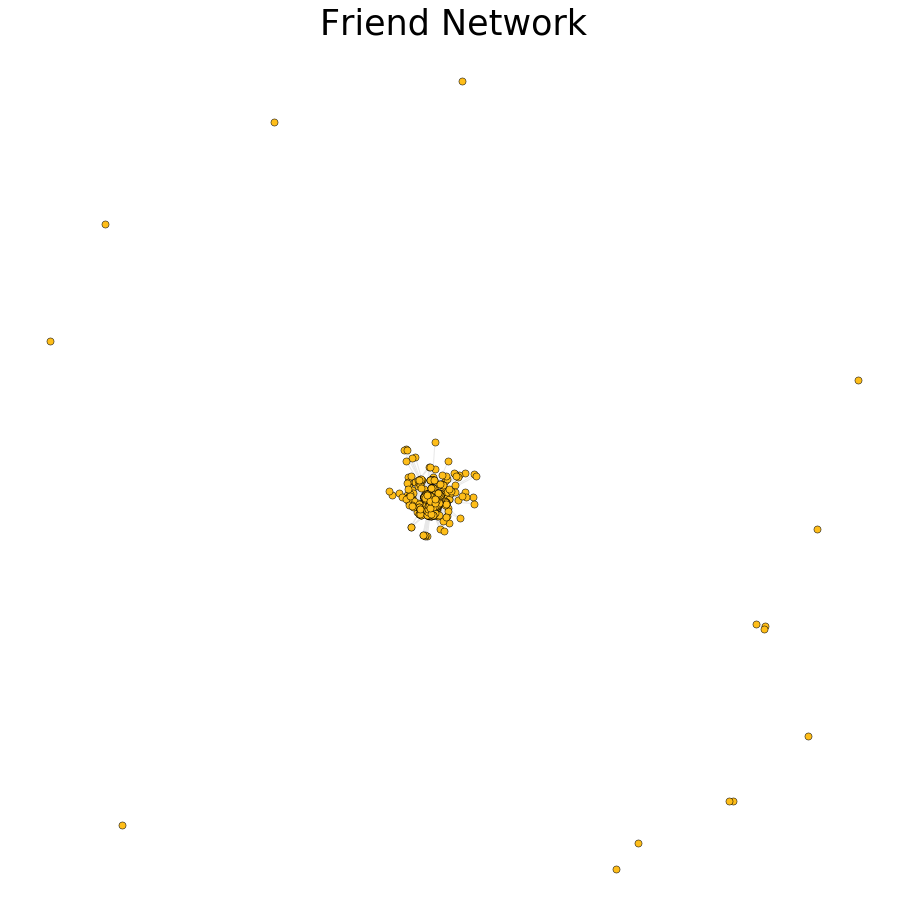

<Figure size 28800x28800 with 0 Axes>

In [13]:
plt.figure(figsize=(16,16))
plt.axis('off')
plt.title('Friend Network', fontsize = 35)
    
nx.draw(G,
        pos=nx.spring_layout(G),
        with_labels = False,
        node_size = 50,
        node_color = '#ffbe19',
        edgecolors='#000000',
        edge_color='#e8e8e8')

plt.figure(figsize=(400,400))

plt.show()

This network graph seems a little bit lopsided since there are lots of nodes around the central cluster of nodes, so I decided to remode those nodes whose degree is less than 2 and add the color to each node by their cities.

In [14]:
degree_threshold = 2 # remove all nodes with degree <= 2

remove = [node 
          for node, degree in G.degree() 
          if degree <= degree_threshold]

G.remove_nodes_from(remove)

In [15]:
nx.info(G)

'Name: \nType: Graph\nNumber of nodes: 1322\nNumber of edges: 246622\nAverage degree: 373.1044'

In [16]:
nx.density(G)

0.2824408685026358

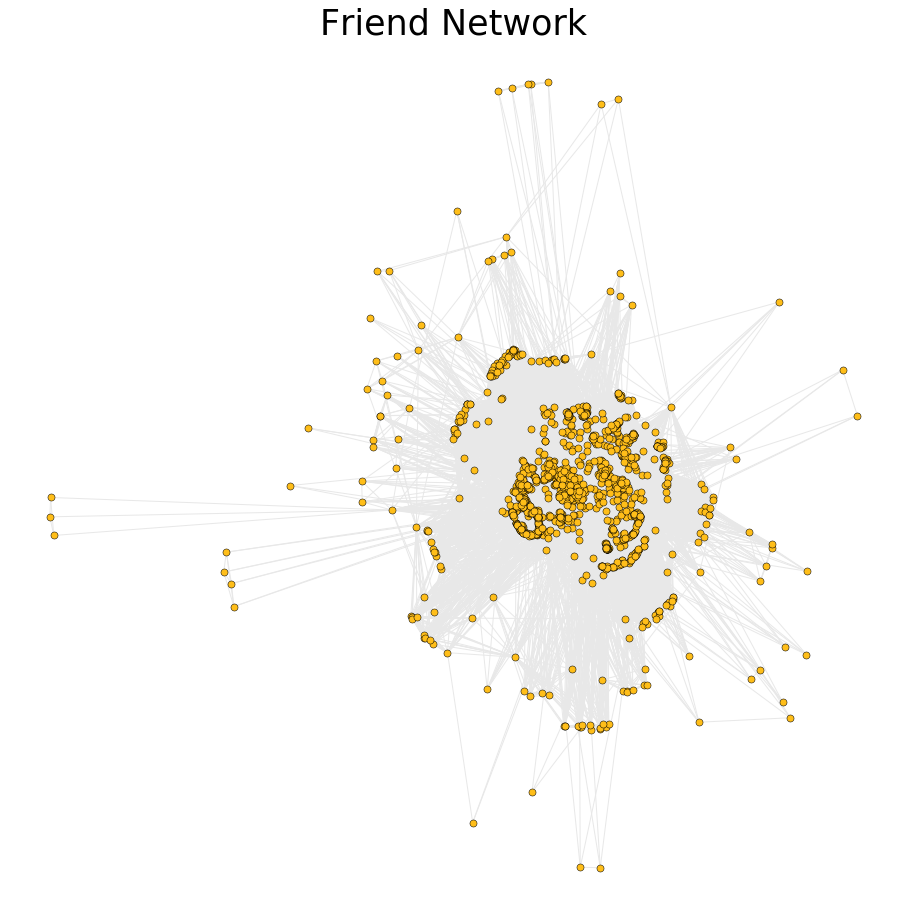

<Figure size 28800x28800 with 0 Axes>

In [17]:
plt.figure(figsize=(16,16))
plt.axis('off')
plt.title('Friend Network', fontsize = 35)
    
nx.draw(G,
        pos=nx.spring_layout(G),
        with_labels = False,
        node_size = 50,
        node_color = '#ffbe19',
        edgecolors='#000000',
        edge_color='#e8e8e8')

plt.figure(figsize=(400,400))

plt.show()

The network looks much better than before.

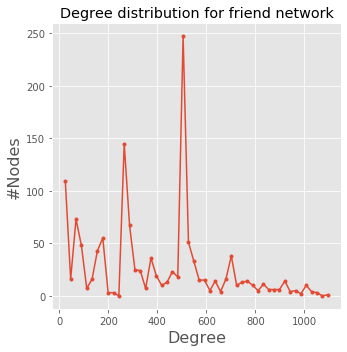

In [18]:
# Degree distribution for random network

degrees = np.array(list(dict(G.degree()).values()))

deg_val,deg_bins = np.histogram(degrees, bins = 50)

plt.figure(figsize = (5,5))

plt.xlabel("Degree", size = 16)
plt.ylabel("#Nodes", size = 16)
plt.title('Degree distribution for friend network')
plt.tight_layout()

plt.plot(deg_bins[1:], deg_val, marker = '.')

plt.savefig("degree-distribution-friend.png", dpi = 400)

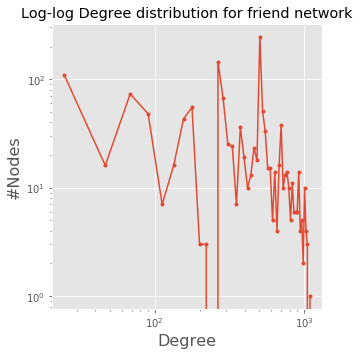

In [19]:
# Degree distribution for random network

degrees = np.array(list(dict(G.degree()).values()))

deg_val,deg_bins = np.histogram(degrees, bins = 50)

plt.figure(figsize = (5,5))

plt.xlabel("Degree", size = 16)
plt.ylabel("#Nodes", size = 16)
plt.title('Log-log Degree distribution for friend network')
plt.tight_layout()

plt.loglog(deg_bins[1:], deg_val, marker = '.')

plt.savefig("loglog-degree-distribution-friend.png", dpi = 400)

In [41]:
attribute = {}

for index, row in friend_network.iterrows():
    name = row["business_id"]

    # Store attributes
    attribute[name] = {"categories": row["categories"], "city": row["city"], 
                       "is_open": row["is_open"], "latitude": row["latitude"],
                       "longitude": row["longitude"], "name": row["name"], 
                       "review_count": row["review_count"], "restaurant_star": row["restaurant_star"],
                       "reviews": row["reviews"]}

In [42]:
nx.set_node_attributes(G, attribute)

In [54]:
node_degrees = []
node_color = []
degree_dict = dict(nx.degree(G))

for node in G.nodes(data=True):
    node_degrees.append(degree_dict[node[0]])
    if node[1]["review_count"] <= 25:
        node_color.append("#ffe6e6")
    elif node[1]["review_count"] > 25 and node[1]["review_count"] <= 50:
        node_color.append("#ffb3b3")
    elif node[1]["review_count"] > 50 and node[1]["review_count"] <= 75:
        node_color.append("#ff8080")
    elif node[1]["review_count"] > 75 and node[1]["review_count"] <= 100:
        node_color.append("#ff4d4d")
    elif node[1]["review_count"] > 100 and node[1]["review_count"] <= 150:
        node_color.append("#ff1a1a")
    elif node[1]["review_count"] > 150 and node[1]["review_count"] <= 200:
        node_color.append("#e60000")
    elif node[1]["review_count"] > 200 and node[1]["review_count"] <= 400:
        node_color.append("#b30000")
    elif node[1]["review_count"] > 400 and node[1]["review_count"] <= 600:
        node_color.append("#800000")
    else:
        node_color.append("#4d0000")

Now we are ready to find optimal positions of each node. First, we create some initial node posistions using the spring_layout method from networkx. Use an undirected version of the graph to find the nodes positions for better results.

In [55]:
# Use an undirected version of the graph to find the nodes positions for better results
node_pos = nx.spring_layout(G.to_undirected(), k=0.15, pos=None, fixed=None, iterations=40, seed=5)

# ForceAtlas2 is a force-directed layout close to other algorithms used for network spatialization    
forceatlas2 = ForceAtlas2(
                          # Behavior alternatives
                          outboundAttractionDistribution=True,  # Dissuade hubs
                          linLogMode=False,  # NOT IMPLEMENTED
                          adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                          edgeWeightInfluence=1.0,

                          # Performance
                          jitterTolerance=1.0,  # Tolerance
                          barnesHutOptimize=True,
                          barnesHutTheta=1.2,
                          multiThreaded=False,  # NOT IMPLEMENTED

                          # Tuning
                          scalingRatio=2.0,
                          strongGravityMode=False,
                          gravity=1.0,

                          # Log
                          verbose=True)

positions = forceatlas2.forceatlas2_networkx_layout(G.to_undirected(), node_pos, 2000)

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:47<00:00, 42.24it/s]


BarnesHut Approximation  took  10.08  seconds
Repulsion forces  took  27.19  seconds
Gravitational forces  took  0.18  seconds
Attraction forces  took  8.12  seconds
AdjustSpeedAndApplyForces step  took  0.81  seconds


In [56]:
len(node_color)

1322

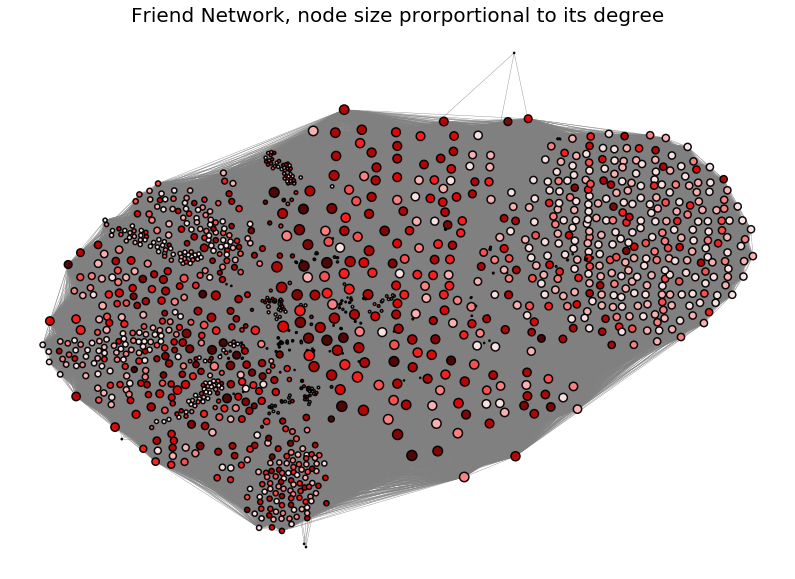

In [57]:
# Plot the network graph

plt.figure(figsize=(14,10))
nx.draw_networkx(G, pos=positions, with_labels=False, front_weight='bold',
                 node_size=[1+0.1*scale for scale in node_degrees],
                 alpha=0.95, edgecolors='#000000', linewidths=1.5, width=0.4,
                 node_color=node_color, edge_color='#808080')

plt.axis('off')
plt.title('Friend Network, node size prorportional to its degree', fontsize=20)

plt.savefig("Friend Network, node size prorportional to its degree", dpi = 400)

plt.show()

As we can see from the graph with beautiful colours above, it makes sense that the businesses from same city are prone to aggregate together because it is more possible for the people to visit two business in one city. Moreover, there are also lots of edges between different cities, which means the American also visit other businesses which are located in other cities.

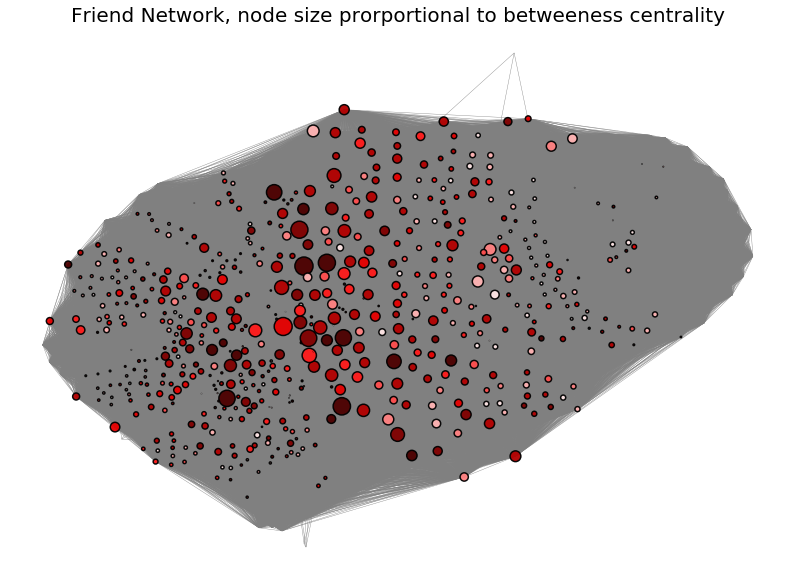

In [58]:
betweenness_centrality = nx.betweenness_centrality(G.to_undirected())
node_size_between = [betweenness_centrality[node] for node in G.nodes()]


plt.figure(figsize=(14,10))
nx.draw_networkx(G, pos=positions, with_labels=False, front_weight='bold',
                 node_size=[30000*scale for scale in node_size_between],
                 alpha=0.95, edgecolors='#000000', linewidths=1.5, width=0.4,
                 node_color=node_color,  edge_color='#808080')

plt.axis('off')
plt.title("Friend Network, node size prorportional to betweeness centrality", fontsize=20)

plt.savefig("Friend Network, node size prorportional to betweeness centrality", dpi = 400)

plt.show()

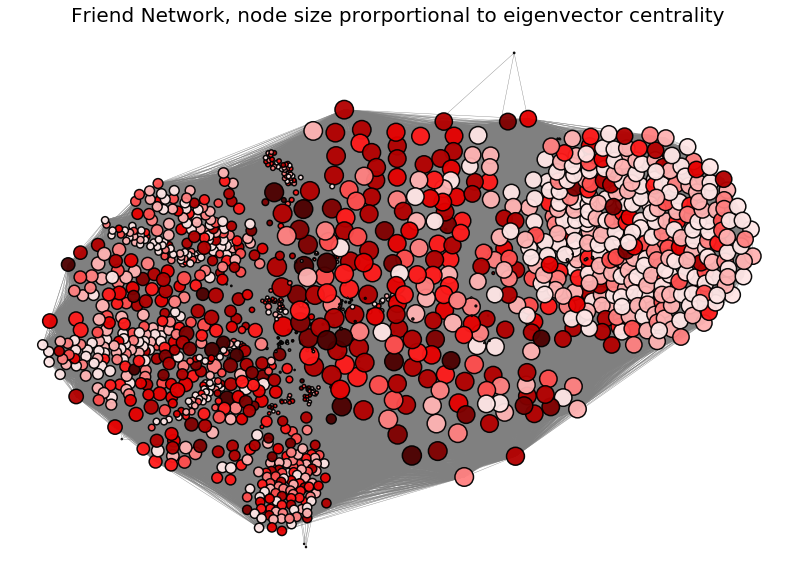

In [59]:
eigenvector_centrality = nx.eigenvector_centrality_numpy(G.to_undirected())
node_size_eigen = [eigenvector_centrality[node] for node in G.nodes()]


plt.figure(figsize=(14,10))
nx.draw_networkx(G, pos=positions, with_labels=False, front_weight='bold',
                 node_size=[7000*scale for scale in node_size_eigen],
                 alpha=0.95, edgecolors='#000000', linewidths=1.5, width=0.4,
                 node_color=node_color, edge_color='#808080')

plt.axis('off')
plt.title("Friend Network, node size prorportional to eigenvector centrality", fontsize=20)

plt.savefig("Friend Network, node size prorportional to eigenvector centrality", dpi = 400)

plt.show()

I am going to use the louvain method to identify the community in business network. Since this method only works on the undirected graphs, I will use networkX function to convert it into undirected graph. What's more, since each disconnected node will be assigned to its own community, I will remove those disconnected nodes from the network. 

In [60]:
G_without_isolated = G.to_undirected()
isolated_nodes = set(nx.isolates(G_without_isolated))
G_without_isolated.remove_nodes_from(isolated_nodes)

In [61]:
import community

partition = community.best_partition(G_without_isolated)
print("modularity: {0}".format(community.modularity(partition, G_without_isolated)))

modularity: 0.288850185427648


In [62]:
partition = community.best_partition(G_without_isolated)

node_color = plt.cm.gist_rainbow
color_value = [node_color(value) for value in np.linspace(0, 1,len(set(partition.values())))]

degree_dict = dict(nx.degree(G))
node_degree = []
node_color = []

for node in G_without_isolated.nodes(data=True):
    node_degree.append(degree_dict[node[0]])
    part_nodes = partition[node[0]]
    node_color.append(color_value[part_nodes])

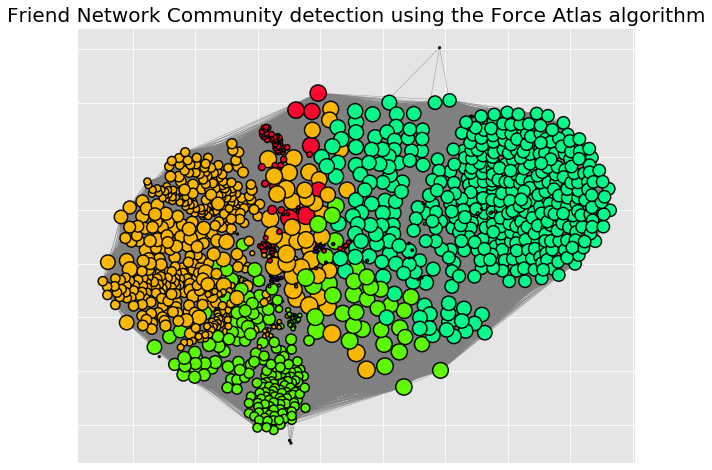

In [64]:
plt.figure(figsize=(10,8))
nx.draw_networkx(G_without_isolated, pos=positions, with_labels=False, front_weight='bold',
        node_size=[2+0.3*scale for scale in node_degrees],
        alpha=0.95, edgecolors='#000000', linewidths=1.5, width=0.4,
        node_color=node_color, edge_color='#808080')

plt.title("Friend Network Community detection using the Force Atlas algorithm", fontsize=20)

plt.savefig("Friend Network, Community detection using the Force Atlas algorithm.png", dpi = 400)

plt.show()

As we can see above, the community partition, it shows almost the same result as before, each natural cluster is detected as a community.

# Calculate distance between two nodes based on coordinates 

In [32]:
from math import sin, cos, sqrt, atan2, radians

def distance(lat1, lon1, lat2, lon2):

    # approximate the radius of earth
    R = 6373

    dlon = radians(lon2)-radians(lon1)
    dlat = radians(lat2)-radians(lat1)

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    
    return distance

In [33]:
# Create your dictionary class 
class my_dictionary(dict): 
  
    # __init__ function 
    def __init__(self): 
        self = dict() 
          
    # Function to add key:value 
    def add(self, key, value): 
        self[key] = value 
   

dict_obj = my_dictionary() 
  
for node1 in G.nodes(data=True):
    for node2 in G.nodes(data=True):
        if node1[0] != node2[0]:
            edge = (node1,node2)
            edge_distance = distance(node1[1]['latitude'], node1[1]['longitude'], node2[1]['latitude'], node2[1]['longitude'])
            #G[node1][node2]['distance'] = {edge_distance}    
            dict_obj.add(dict(node1, node2), 'distance', edge_distance) 

TypeError: dict expected at most 1 arguments, got 2

In [ ]:
for node1 in G.nodes(data=True):
    for node2 in G.nodes(data=True):
        if node1[0] != node2[0]:
            edge = (node1,node2)
            edge_attribute = distance(node1[1]['latitude'], node1[1]['longitude'], node2[1]['latitude'], node2[1]['longitude'])
            G[node1][node2]['distance'] = {edge_attribute}
            

## Define a function that return the list includes top 10 restaurant with highest degree

In [65]:
def select_top_10(restaurant_name):  
    degree_list = sorted(G.degree, key=lambda x: x[1], reverse=True)

    node_list = []
    for u,v in G.edges(name):
        node_list.append(v)

    list_ = []
    for i in range(len(node_list)):
        for j in range(len(degree_list)):
            if node_list[i] == degree_list[j][0]:    
                list_.append(degree_list[j]) 

    final_list = pd.DataFrame(list_)

    final_list.columns = ['business_id','degree']

    degree_final_list = final_list.sort_values(by=['degree'],ascending=False)

    return degree_final_list.head(10)

In [66]:
select_top_10('5PyqkF8zZbfgFDyAcLUehQ')

,business_id,degree
8,Gsbt1IoWkjrh9nExM7BIFw,627
9,jeVA5jD1hvloJLA1xPbocA,554
2,EcQKWKM1-1WQJAX2fUVCkw,509
3,3fblSVANhY1YGnwGstRL8w,509
11,3Ya7kCGgS5X62ibV1ZcjCA,509
1,vBNM4NEBuO66Hk5yO797eA,494
0,5fquJHY2hMX9tPRD5s0t5g,63
7,wU8Sld-ehrRXiuH1QcWTcg,17
4,qeixzOYuWFPy8uKrOfuapg,7
10,zki75FDORLkeFQvf2vmF8w,7
